In [38]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import time
%matplotlib inline 

import keras.backend as K
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner import HyperModel
from keras_tuner.tuners import Hyperband

from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout

from pylab import rcParams

from scipy import stats
from scipy.stats import norm
from scipy.stats import skew

import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels import tsa

from tensorflow import keras

### Dataset Preparation

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


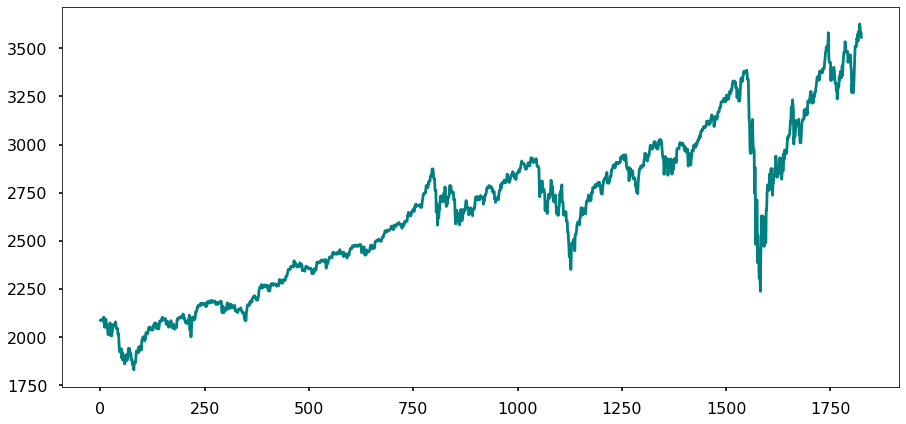

In [2]:
data = pd.read_csv("yahoo_stock.csv")
close_series = data.Close
plt.style.use('seaborn-poster')
close_series.plot(figsize=(15, 7), color = 'teal')
data.head()

In [3]:
data.Date.min(), data.Date.max()

('2015-11-23', '2020-11-20')

In [4]:
feats = ['Date', 'Close', 'Volume']
train= data[feats].copy()
train.head()

,Date,Close,Volume
0,2015-11-23,2086.590088,3.587980e+09
1,2015-11-24,2089.139893,3.884930e+09
2,2015-11-25,2088.870117,2.852940e+09
3,2015-11-26,2088.870117,2.852940e+09
4,2015-11-27,2090.110107,1.466840e+09


In [5]:
ts_series = train.Close

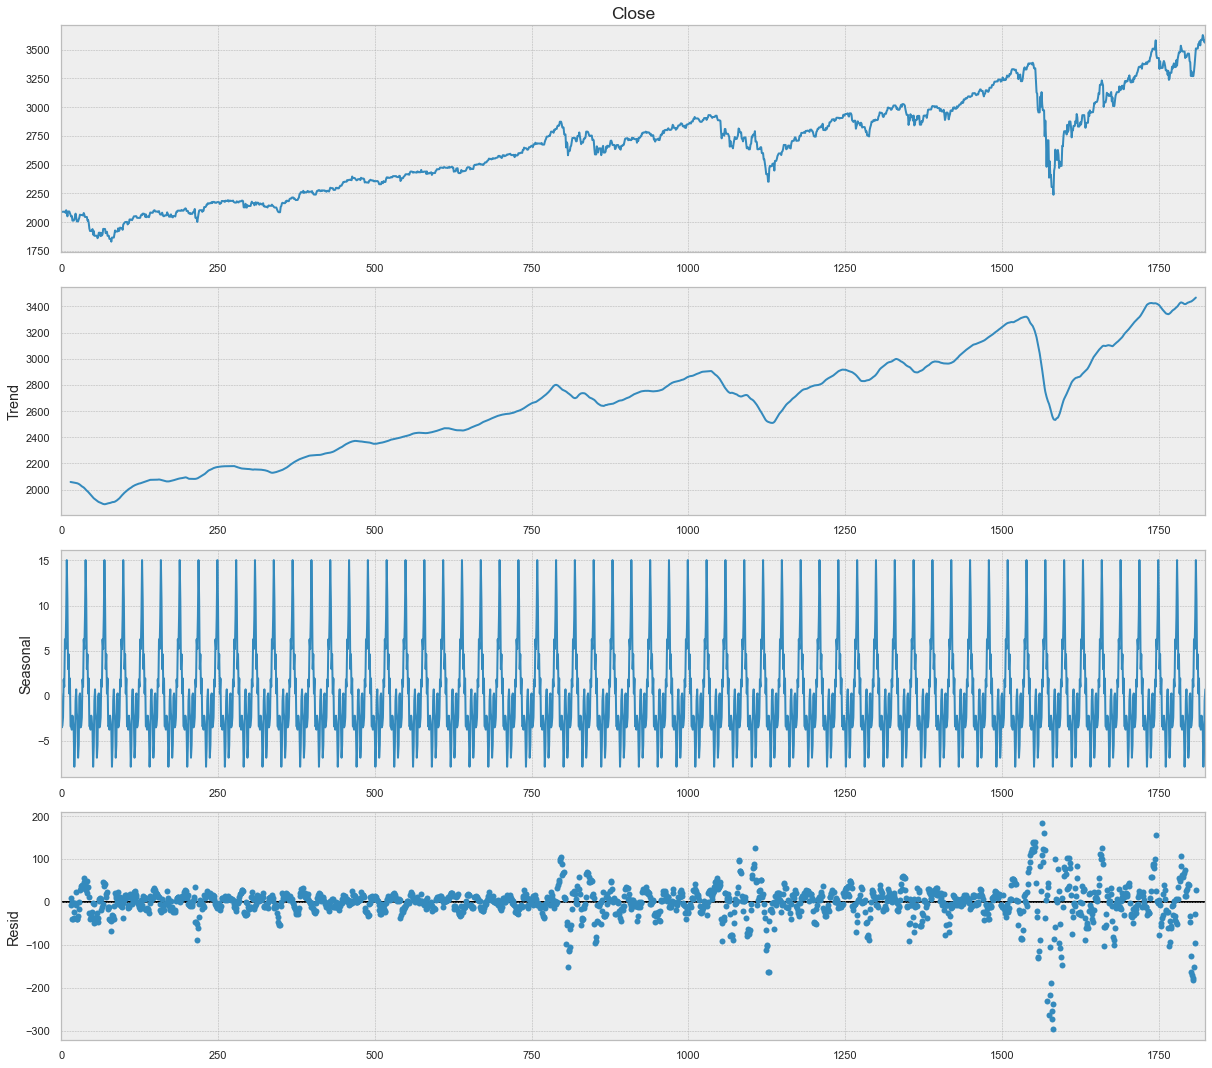

In [6]:
rcParams['figure.figsize'] = 17,15
rcParams['lines.color'] = 'teal'

result = seasonal_decompose(ts_series, model='additive', period=30)
sns.set()

plt.style.use('bmh')
result.plot()

plt.show()

In [7]:
train['Date'] = pd.to_datetime(train.Date, format='%Y-%m-%d')

In [8]:
train.Date.dtypes

dtype('<M8[ns]')

In [9]:
# Building block samples
train['year'] = train.Date.dt.year
train['month'] = train.Date.dt.month
train['day'] = train.Date.dt.day
train['week']=train.Date.dt.week
train['quarter']=train.Date.dt.quarter
train.head()

,Date,Close,Volume,year,month,day,week,quarter
0,2015-11-23,2086.590088,3.587980e+09,2015,11,23,48,4
1,2015-11-24,2089.139893,3.884930e+09,2015,11,24,48,4
2,2015-11-25,2088.870117,2.852940e+09,2015,11,25,48,4
3,2015-11-26,2088.870117,2.852940e+09,2015,11,26,48,4
4,2015-11-27,2090.110107,1.466840e+09,2015,11,27,48,4


In [10]:
train['month_block'] = train['year'].astype(str) + train['month'].astype(str)
train.head()

,Date,Close,Volume,year,month,day,week,quarter,month_block
0,2015-11-23,2086.590088,3.587980e+09,2015,11,23,48,4,201511
1,2015-11-24,2089.139893,3.884930e+09,2015,11,24,48,4,201511
2,2015-11-25,2088.870117,2.852940e+09,2015,11,25,48,4,201511
3,2015-11-26,2088.870117,2.852940e+09,2015,11,26,48,4,201511
4,2015-11-27,2090.110107,1.466840e+09,2015,11,27,48,4,201511


In [11]:
train['month_block'].unique().size

61

In [12]:
train['week_block'] = train['year'].astype(str) + train['month'].astype(str) + train['week'].astype(str)
train.head()

,Date,Close,Volume,year,month,day,week,quarter,month_block,week_block
0,2015-11-23,2086.590088,3.587980e+09,2015,11,23,48,4,201511,20151148
1,2015-11-24,2089.139893,3.884930e+09,2015,11,24,48,4,201511,20151148
2,2015-11-25,2088.870117,2.852940e+09,2015,11,25,48,4,201511,20151148
3,2015-11-26,2088.870117,2.852940e+09,2015,11,26,48,4,201511,20151148
4,2015-11-27,2090.110107,1.466840e+09,2015,11,27,48,4,201511,20151148


In [13]:
train['week_block'].unique().size

313

The dates of the data is now seperated into quarter, month, and week blocks to generate partitioned analysis

In [14]:
X = train.groupby(['week_block'])['Close'].mean().rename('mean_Close').reset_index()

## EDA

In [15]:
target = X.pop('mean_Close')

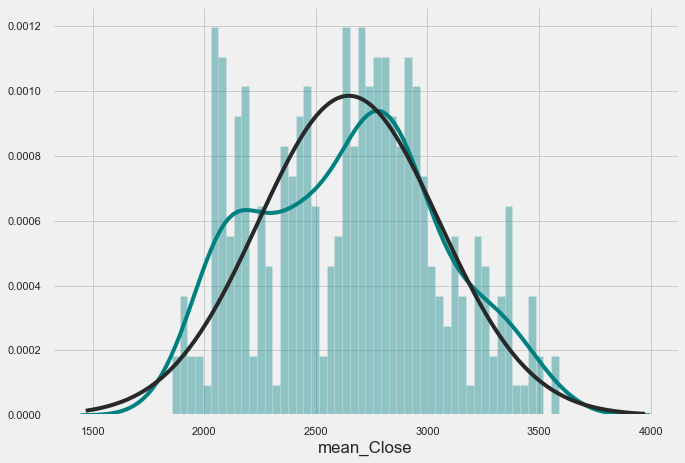

In [16]:
#visualize distribution of weekly stocks
sns.set()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 7))
sns.distplot(target,bins=50, fit=norm, kde=True, color='teal')

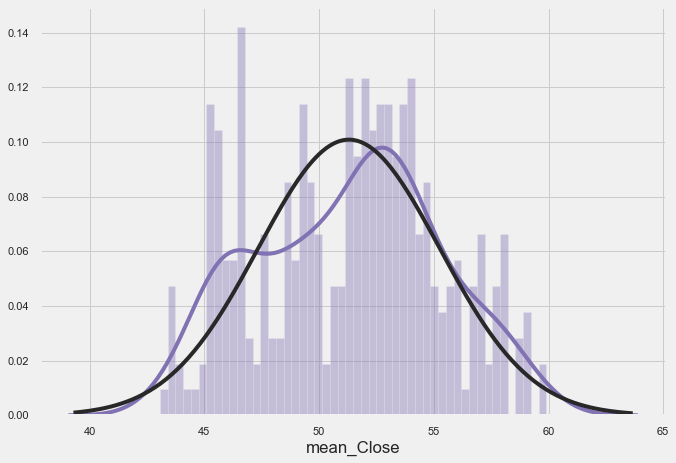

In [17]:
#Visualize normalized distribution of stocks
sns.set()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 7))
sns.distplot(np.sqrt(target),bins=50, fit=norm, kde=True, color='m')

## Series Preparation

In [18]:
TRAIN_PERCENT = 0.8
def get_seq_train_test(time_series, scaling=True,train_size=0.8):
    scaler = None
    if scaling:
        scaler = MinMaxScaler(feature_range=(0, 1))
        time_series = np.array(time_series).reshape(-1,1)
        scaled_stock_series = scaler.fit_transform(time_series)
    else:
        scaled_stock_series = time_series
        
    train_size = int(len(scaled_stock_series) * train_size)

    train = scaled_stock_series[0:train_size]
    test = scaled_stock_series[train_size:len(scaled_stock_series)]
    
    return train,test,scaler

In [19]:
train,test,scaler = get_seq_train_test(close_series,
                                   scaling=True,
                                   train_size=TRAIN_PERCENT)

In [20]:
train = np.reshape(train,(1,train.shape[0],1))
test = np.reshape(test,(1,test.shape[0],1))

X_train = train[:,:-1,:]
y_train = train[:,1:,:]

X_test = test[:,:-1,:]
y_test = test[:,1:,:]

In [21]:
print("X_train {}".format(X_train.shape))
print("y_train {}".format(y_train.shape))
print("X_test {}".format(X_test.shape))
print("y_test {}".format(y_test.shape))

X_train (1, 1459, 1)
y_train (1, 1459, 1)
X_test (1, 364, 1)
y_test (1, 364, 1)


## Model1

In [71]:
K.clear_session()

In [23]:
def create_RNN_model(hidden_units=7,input_shape=(1,1),verbose=False):
    
    model = Sequential()
    
    model.add(LSTM(input_shape=input_shape, units = hidden_units, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(input_shape=input_shape, units = hidden_units, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(1)))
    
    model.compile(loss="mse", optimizer="rmsprop", metrics = ['accuracy'])
    
    return model

In [24]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=0)]

In [25]:
model1 = create_RNN_model(input_shape=(X_train.shape[1],1), verbose= True)

In [26]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1459, 7)           252       
_________________________________________________________________
dropout (Dropout)            (None, 1459, 7)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1459, 7)           420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1459, 7)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 1459, 1)           8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
_________________________________________________________________


In [27]:
start = time.time()
modelfit1 = model1.fit(X_train, y_train, epochs=150, batch_size=16, callbacks = callbacks)
end = time.time()
print("Training took {:.2f}s".format(end - start))

Epoch 1/150
1/1 [==============================] - 0s 2ms/step - loss: 0.5137 - accuracy: 6.8540e-04
Epoch 2/150
1/1 [==============================] - 0s 2ms/step - loss: 0.4217 - accuracy: 6.8540e-04
Epoch 3/150
1/1 [==============================] - 0s 2ms/step - loss: 0.3742 - accuracy: 6.8540e-04
Epoch 4/150
1/1 [==============================] - 0s 2ms/step - loss: 0.3305 - accuracy: 6.8540e-04
Epoch 5/150
1/1 [==============================] - 0s 2ms/step - loss: 0.2937 - accuracy: 6.8540e-04
Epoch 6/150
1/1 [==============================] - 0s 2ms/step - loss: 0.2655 - accuracy: 6.8540e-04
Epoch 7/150
1/1 [==============================] - 0s 2ms/step - loss: 0.2394 - accuracy: 6.8540e-04
Epoch 8/150
1/1 [==============================] - 0s 2ms/step - loss: 0.2132 - accuracy: 6.8540e-04
Epoch 9/150
1/1 [==============================] - 0s 2ms/step - loss: 0.1957 - accuracy: 6.8540e-04
Epoch 10/150
1/1 [==============================] - 0s 1ms/step - loss: 0.1705 - accuracy: 

1/1 [==============================] - 0s 2ms/step - loss: 0.0389 - accuracy: 6.8540e-04
Epoch 28/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0411 - accuracy: 6.8540e-04
Epoch 29/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0416 - accuracy: 6.8540e-04
Epoch 30/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0376 - accuracy: 6.8540e-04
Epoch 31/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0369 - accuracy: 6.8540e-04
Epoch 32/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0364 - accuracy: 6.8540e-04
Epoch 33/150
1/1 [==============================] - 0s 1ms/step - loss: 0.0396 - accuracy: 6.8540e-04
Epoch 34/150
1/1 [==============================] - 0s 989us/step - loss: 0.0353 - accuracy: 6.8540e-04
Epoch 35/150
1/1 [==============================] - 0s 1ms/step - loss: 0.0403 - accuracy: 6.8540e-04
Epoch 36/150
1/1 [==============================] - 0s 996us/step - loss: 0.0377 - accuracy: 

1/1 [==============================] - 0s 2ms/step - loss: 0.0258 - accuracy: 6.8540e-04
Epoch 54/150
1/1 [==============================] - 0s 3ms/step - loss: 0.0256 - accuracy: 6.8540e-04
Epoch 55/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0229 - accuracy: 6.8540e-04
Epoch 56/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 6.8540e-04
Epoch 57/150
1/1 [==============================] - 0s 997us/step - loss: 0.0212 - accuracy: 6.8540e-04
Epoch 58/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0217 - accuracy: 6.8540e-04
Epoch 59/150
1/1 [==============================] - 0s 997us/step - loss: 0.0221 - accuracy: 6.8540e-04
Epoch 60/150
1/1 [==============================] - 0s 998us/step - loss: 0.0216 - accuracy: 6.8540e-04
Epoch 61/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 6.8540e-04
Epoch 62/150
1/1 [==============================] - 0s 997us/step - loss: 0.0204 - accura

1/1 [==============================] - 0s 2ms/step - loss: 0.0133 - accuracy: 6.8540e-04
Epoch 80/150
1/1 [==============================] - 0s 997us/step - loss: 0.0128 - accuracy: 6.8540e-04
Epoch 81/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0133 - accuracy: 6.8540e-04
Epoch 82/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 6.8540e-04
Epoch 83/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0135 - accuracy: 6.8540e-04
Epoch 84/150
1/1 [==============================] - 0s 993us/step - loss: 0.0119 - accuracy: 6.8540e-04
Epoch 85/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0123 - accuracy: 6.8540e-04
Epoch 86/150
1/1 [==============================] - 0s 997us/step - loss: 0.0113 - accuracy: 6.8540e-04
Epoch 87/150
1/1 [==============================] - 0s 1ms/step - loss: 0.0114 - accuracy: 6.8540e-04
Epoch 88/150
1/1 [==============================] - 0s 998us/step - loss: 0.0109 - accura

1/1 [==============================] - 0s 998us/step - loss: 0.0096 - accuracy: 6.8540e-04
Epoch 106/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 6.8540e-04
Epoch 107/150
1/1 [==============================] - 0s 1ms/step - loss: 0.0097 - accuracy: 6.8540e-04
Epoch 108/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0081 - accuracy: 6.8540e-04
Epoch 109/150
1/1 [==============================] - 0s 997us/step - loss: 0.0097 - accuracy: 6.8540e-04
Epoch 110/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0089 - accuracy: 6.8540e-04
Epoch 111/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 6.8540e-04
Epoch 112/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0094 - accuracy: 6.8540e-04
Epoch 113/150
1/1 [==============================] - 0s 998us/step - loss: 0.0090 - accuracy: 6.8540e-04
Epoch 114/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0093 -

1/1 [==============================] - 0s 984us/step - loss: 0.0084 - accuracy: 6.8540e-04
Epoch 132/150
1/1 [==============================] - 0s 1ms/step - loss: 0.0078 - accuracy: 6.8540e-04
Epoch 133/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0075 - accuracy: 6.8540e-04
Epoch 134/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0074 - accuracy: 6.8540e-04
Epoch 135/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 6.8540e-04
Epoch 136/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0081 - accuracy: 6.8540e-04
Epoch 137/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0076 - accuracy: 6.8540e-04
Epoch 138/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 6.8540e-04
Epoch 139/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0078 - accuracy: 6.8540e-04
Epoch 140/150
1/1 [==============================] - 0s 2ms/step - loss: 0.0071 - acc

In [28]:
y_pred1 = model1.predict(X_train)
score1 = math.sqrt(mean_squared_error(y_train[0], y_pred1[0]))
print('Model1 Score: %.2f RMSE' % (score1))

Model1 Score: 0.03 RMSE


In [29]:
from keras.preprocessing.sequence import pad_sequences

testpred1 = pad_sequences(X_test,
                                maxlen= X_train.shape[1],
                                padding='post',
                                dtype='float64')

In [30]:
testpred1 = model1.predict(testpred1)

# evaluate performances
testScore = math.sqrt(mean_squared_error(y_test[0], 
                                         testpred1[0][:X_test.shape[1]]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.15 RMSE


In [31]:
y_pred1 = scaler.inverse_transform(y_pred1.reshape(-1, 1))
testpred1 = scaler.inverse_transform(testpred1.reshape(-1, 1))

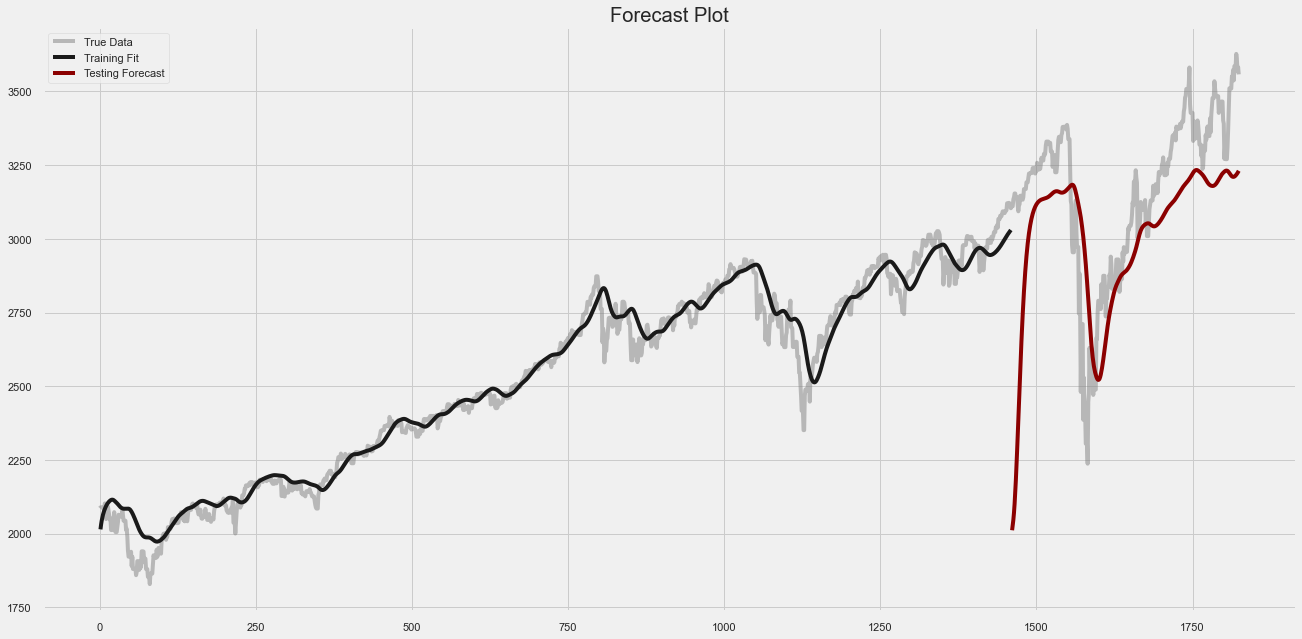

In [32]:
model_size = len(y_pred1)+1
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 10))
plt.plot(close_series.index, close_series.values,c='grey', alpha=0.5,label='True Data')
plt.plot(close_series.index[1:model_size], y_pred1,label='Training Fit', c='k')
plt.plot(close_series.index[model_size+1:], testpred1[:X_test.shape[1]],label='Testing Forecast', c='darkred', linewidth=4)
plt.title('Forecast Plot')
plt.legend()
plt.show()

In [33]:
#create 1D array of y_test for validation
y_preds1 = model1.predict(X_train)
preds1 = y_preds1[0]
y_true = y_train[0]

In [34]:
mae = metrics.mean_absolute_error(y_true, preds1)
mse = metrics.mean_squared_error(y_true, preds1)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y_true, preds1)

In [35]:
print("Model 1 metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Model 1 metrics:
MAE: 0.02229197889344064
MSE: 0.0010024819192313804
RMSE: 0.031661994871318204
R-Squared: 0.9695199938145478


## Hyperparameter Tuning

In [72]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(32,return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(LSTM(32,return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(TimeDistributed(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu'))))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

In [73]:
tuner= RandomSearch(
        build_model,
        objective='mse',
        max_trials=2,
        executions_per_trial= 1,
        project_name= 'model 2',
        directory= os.path.normpath('C:/james/Desktop/time_series')
        )

In [74]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}


In [75]:
start = time.time()
tuner.search(X_train,y_train, epochs=100, batch_size=16)
end = time.time()
print("Searching took {:.2f}s".format(end - start))

Trial 2 Complete [00h 03m 19s]
mse: 0.002176996087655425

Best mse So Far: 0.0015624722000211477
Total elapsed time: 00h 06m 38s
INFO:tensorflow:Oracle triggered exit
Searching took 398.44s


In [76]:
tuner.results_summary()

Results summary
Results in C:\james\Desktop\time_series\model 2
Showing 10 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
Dropout_rate: 0.1
dense_activation: sigmoid
Score: 0.0015624722000211477
Trial summary
Hyperparameters:
Dropout_rate: 0.4
dense_activation: sigmoid
Score: 0.002176996087655425


## Model 2

In [101]:
# Retrieve the best model.
best_model = tuner.get_best_models()[0]

In [102]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1459, 32)          4352      
_________________________________________________________________
dropout (Dropout)            (None, 1459, 32)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1459, 32)          8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1459, 32)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 1459, 1)           33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [103]:
y_pred2 = best_model.predict(X_train)
score2 = math.sqrt(mean_squared_error(y_train[0], y_pred2[0]))
print('Model1 Score: %.2f RMSE' % (score2))

Model1 Score: 0.04 RMSE


In [104]:
from keras.preprocessing.sequence import pad_sequences

testpred2 = pad_sequences(X_test,
                                maxlen= X_train.shape[1],
                                padding='post',
                                dtype='float64')

In [105]:
testpred2 = best_model.predict(X_test)

# evaluate performances
testScore2 = math.sqrt(mean_squared_error(y_test[0], 
                                         testpred2[0][:X_test.shape[1]]))
print('Test Score: %.2f RMSE' % (testScore2))

Test Score: 0.15 RMSE


In [106]:
y_pred2 = scaler.inverse_transform(y_pred2.reshape(-1, 1))
testpred2 = scaler.inverse_transform(testpred2.reshape(-1, 1))

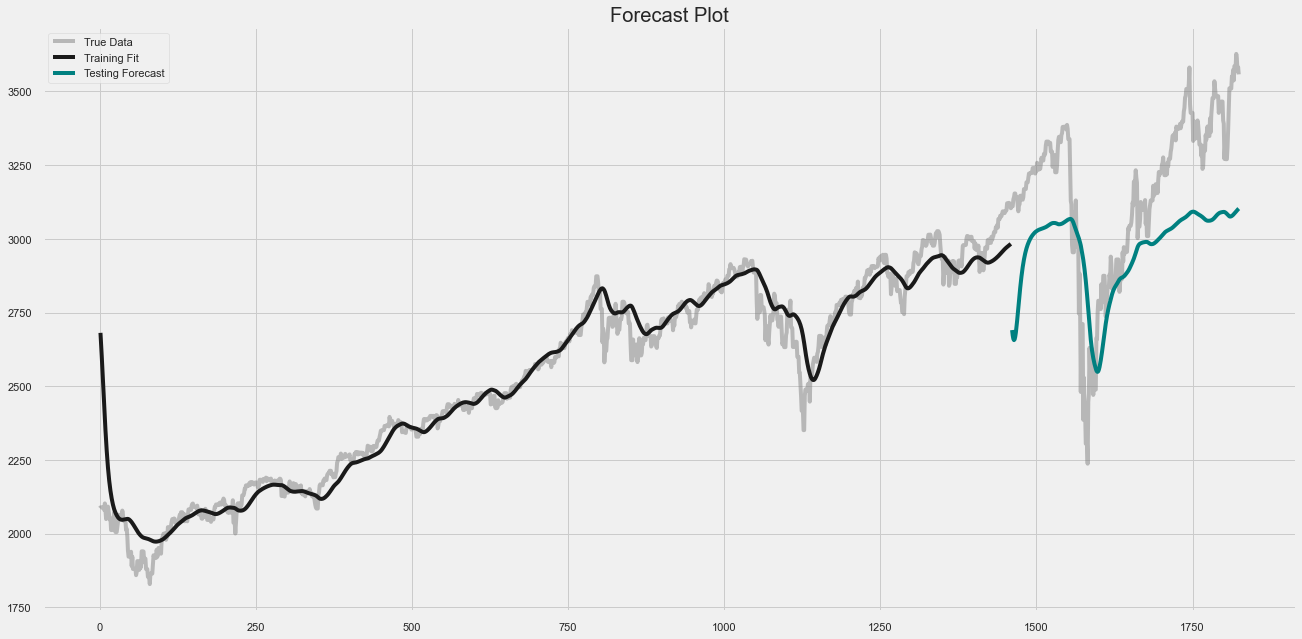

In [107]:
model_size = len(y_pred2)+1
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 10))
plt.plot(close_series.index, close_series.values,c='grey', alpha=0.5,label='True Data')
plt.plot(close_series.index[1:model_size], y_pred2,label='Training Fit', c='k')
plt.plot(close_series.index[model_size+1:], testpred2[:X_test.shape[1]],label='Testing Forecast', c='teal', linewidth=4)
plt.title('Forecast Plot')
plt.legend()
plt.show()

In [108]:
#create 1D array of y_test for validation
y_preds2 = best_model.predict(X_train)
preds2 = y_preds2[0]
y_true = y_train[0]

In [109]:
mae = metrics.mean_absolute_error(y_true, preds2)
mse = metrics.mean_squared_error(y_true, preds2)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_true, preds2)

In [110]:
print("Model 2 metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Model 2 metrics:
MAE: 0.02391785542862004
MSE: 0.0013775206709735286
RMSE: 0.03711496559305328
R-Squared: 0.958117111374883


The model fits well to the training data and slightly poor when compared to the validation set. This model performed at the same level as model one .

## Model 3

In [87]:
tuner2= Hyperband(
        build_model,
        objective='mse',
        max_epochs = 30,
        executions_per_trial=1,
        project_name= 'model 3',
        directory= os.path.normpath('C:/james/Desktop/time_series2')
        )

In [88]:
tuner2.search_space_summary()

Search space summary
Default search space size: 2
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}


In [89]:
tuner2.search(X_train,y_train, epochs=100, batch_size=16)

Trial 12 Complete [00h 00m 19s]
mse: 0.045839786529541016

Best mse So Far: 0.044739313423633575
Total elapsed time: 00h 03m 52s
INFO:tensorflow:Oracle triggered exit


In [90]:
tuner2.results_summary()

Results summary
Results in C:\james\Desktop\time_series2\model 3
Showing 10 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
Dropout_rate: 0.2
dense_activation: sigmoid
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.044739313423633575
Trial summary
Hyperparameters:
Dropout_rate: 0.1
dense_activation: sigmoid
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.045025620609521866
Trial summary
Hyperparameters:
Dropout_rate: 0.5
dense_activation: sigmoid
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.04508611932396889
Trial summary
Hyperparameters:
Dropout_rate: 0.0
dense_activation: sigmoid
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.045839786529541016
Trial summary
Hyperparameters:
Dropout_rate: 0.30000000000000004
dense_activation: sigmoid
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.0460236

In [119]:
# Retrieve the best model.
best_model2 = tuner.get_best_models()[0]

In [120]:
best_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1459, 32)          4352      
_________________________________________________________________
dropout (Dropout)            (None, 1459, 32)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1459, 32)          8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1459, 32)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 1459, 1)           33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [121]:
y_pred3 = best_model2.predict(X_train)
score3 = math.sqrt(mean_squared_error(y_train[0], y_pred3[0]))
print('Model1 Score: %.2f RMSE' % (score3))

Model1 Score: 0.04 RMSE


In [115]:
from keras.preprocessing.sequence import pad_sequences

testpred3 = pad_sequences(X_test,
                                maxlen= X_train.shape[1],
                                padding='post',
                                dtype='float64')

In [116]:
testpred3 = best_model2.predict(X_test)

# evaluate performances
testScore3 = math.sqrt(mean_squared_error(y_test[0], 
                                         testpred3[0][:X_test.shape[1]]))
print('Test Score: %.2f RMSE' % (testScore3))

Test Score: 0.15 RMSE


In [117]:
y_pred3 = scaler.inverse_transform(y_pred3.reshape(-1, 1))
testpred3 = scaler.inverse_transform(testpred3.reshape(-1, 1))

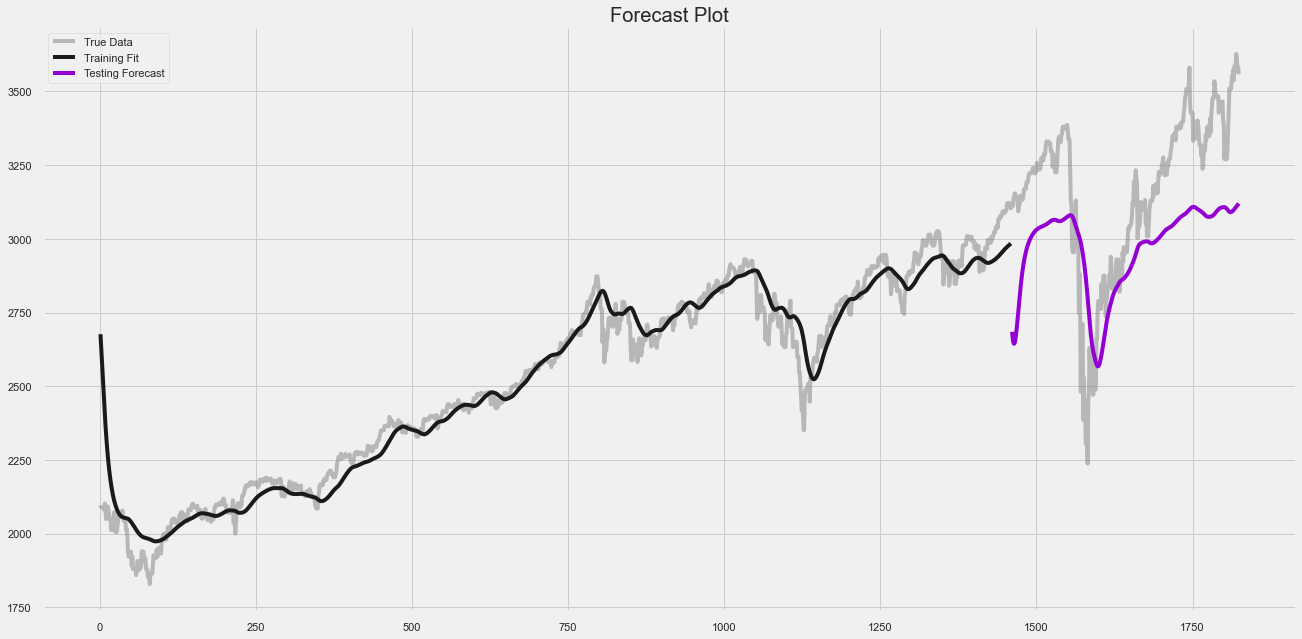

In [118]:
model_size = len(y_pred3)+1
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 10))
plt.plot(close_series.index, close_series.values,c='grey', alpha=0.5,label='True Data')
plt.plot(close_series.index[1:model_size], y_pred3,label='Training Fit', c='k')
plt.plot(close_series.index[model_size+1:], testpred3[:X_test.shape[1]],label='Testing Forecast', c='darkviolet', linewidth=4)
plt.title('Forecast Plot')
plt.legend()
plt.show()

Model 3 performed similar to model 2. The drop out rates we different from one another. It is likely that the two models found the same local optima through different means. It is also likely that the models found optimal solutions based on the shape of the neural network. 